In [1]:
import pandas as pd 
import numpy as np 

with open('./stopwords-ko.txt', 'r') as s:
    stopwords=  s.readlines()

stopwords = [words.strip() for words in stopwords ]

In [2]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
# from konlpy.tag import Okt
from eunjeon import Mecab
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
import urllib.request
from collections import Counter
def pickleIO(obj, src, op="r"):
    if op=="w":
        with open(src, op + "b") as f:
            pickle.dump(obj, f)
    elif op=="r":
        with open(src, op + "b") as f:
            tmp = pickle.load(f)
        return tmp
    else:
        print("unknown operation")
        return obj
    
df= pd.DataFrame()
df_all = pickleIO(df, src='df_full.pkl',op='r')
df_train = pickleIO(df, src='df_train.pkl',op='r')
df_valid = pickleIO(df, src='df_valid.pkl',op='r')

df_train.document=  df_train.document.str.replace('[^가-힣]' , ' ')
df_valid.document=  df_valid.document.str.replace('[^가-힣]' , ' ')

df_train.document = df_train.document.str.replace('^ +', '')
df_valid.document = df_valid.document.str.replace('^ +', '')

df_train.document = df_train.document.replace('', np.nan)
df_valid.document = df_valid.document.replace('', np.nan)
df_train  =  df_train.dropna(how='any')
df_valid  =  df_valid.dropna(how='any')
df_train = df_train.drop_duplicates()
df_valid = df_valid.drop_duplicates()
df_train.label = df_train.label.apply(lambda x: 1 if x=='pos' else 0 )
df_valid.label = df_valid.label.apply(lambda x: 1 if x=='pos' else 0 )
print(df_train.shape , df_valid.shape)

C:\Users\USER\AppData\Local\Temp\ipykernel_25528\465700656.py:32: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train.document=  df_train.document.str.replace('[^가-힣]' , ' ')
C:\Users\USER\AppData\Local\Temp\ipykernel_25528\465700656.py:33: FutureWarning: The default value of regex will change from True to False in a future version.
  df_valid.document=  df_valid.document.str.replace('[^가-힣]' , ' ')
C:\Users\USER\AppData\Local\Temp\ipykernel_25528\465700656.py:35: FutureWarning: The default value of regex will change from True to False in a future version.
  df_train.document = df_train.document.str.replace('^ +', '')


In [ ]:
mecab = Mecab()


df_train['tokenized'] = df_train['document'].apply(mecab.morphs)
df_train['tokenized'] = df_train['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
train_data = df_train.copy()

: 

: 

In [ ]:
df_valid['tokenized'] = df_valid['document'].apply(mecab.morphs)
df_valid['tokenized'] = df_valid['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])
test_data = df_valid.copy()

In [ ]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [ ]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('는', 92806), ('고', 87272), ('도', 57375), ('다', 54826), ('은', 51924), ('네요', 39948), ('안', 37054), ('는데', 33429), ('지', 31439), ('한', 30762), ('영화', 30282), ('게', 28953), ('없', 28664), ('있', 26601), ('너무', 23199), ('보', 21194), ('했', 20712), ('만', 20528), ('거', 18817), ('같', 18775)]
[('고', 84834), ('는', 77122), ('좋', 59318), ('도', 55422), ('다', 46555), ('은', 41553), ('있', 35226), ('게', 34905), ('영화', 31800), ('네요', 31193), ('한', 29747), ('잘', 27080), ('어요', 26012), ('아요', 24397), ('는데', 22547), ('보', 22393), ('지', 19375), ('게임', 18768), ('했', 18189), ('구매', 18045)]


긍정 리뷰의 평균 길이 : 13.901422548454608
부정 리뷰의 평균 길이 : 15.579414531513944


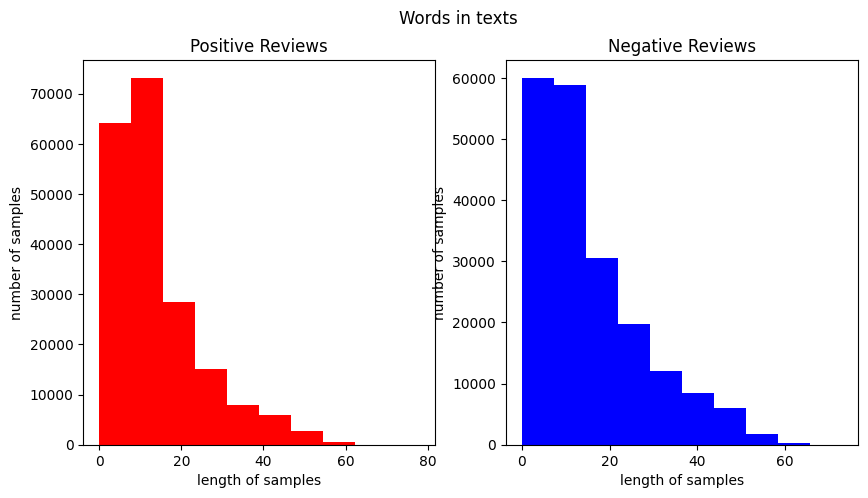

In [ ]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [ ]:
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape,    )

(395536,) (395536,) (99378,) (99378,)


In [ ]:
len(X_train),len(y_train),len(X_test),len(y_test),

(395536, 395536, 99378, 99378)

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)


# 전체 단어 개수 중 빈도수 2이하인 단어 개수는 제거.
# 0번 패딩 토큰과 1번 OOV 토큰을 고려하여 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :',vocab_size)

In [ ]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [ ]:
len(X_train),len(y_train),len(X_test),len(y_test),

(395536, 395536, 99378, 99378)

리뷰의 최대 길이 : 78
리뷰의 평균 길이 : 14.740223393066623


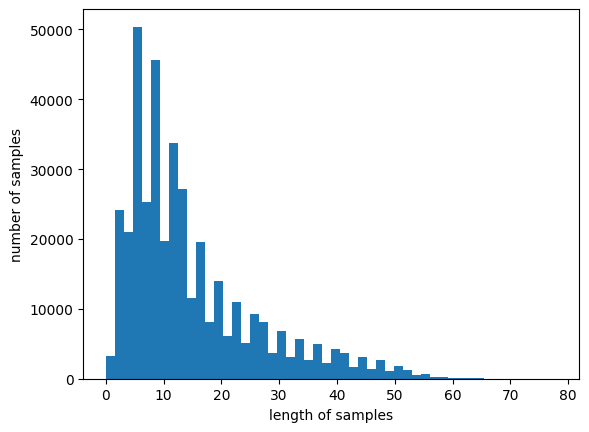

In [32]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [19]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [33]:
max_len = 80
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 99.94058695036608


In [34]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

In [37]:
len(X_train),len(y_train),len(X_test),len(y_test),

(395536, 395536, 99378, 99378)

In [4]:
from tensorflow.keras.layers import Embedding, Dense, GRU , LSTM , Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 500
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(Bidirectional(LSTM(hidden_units , dropout =0.2, recurrent_dropout=0.2  )))
model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
# history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=64, validation_split=0.2)

In [5]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 500)         22969500  
                                                                 
 bidirectional (Bidirectiona  (None, 256)              644096    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 257       
                                                                 
Total params: 23,613,853
Trainable params: 23,613,853
Non-trainable params: 0
_________________________________________________________________


In [47]:
y_test.shape , X_test.shape

((99378,), (99378, 80))

In [2]:
from tensorflow.keras.models import load_model
import tensorflow_addons as tfa

c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file a

In [44]:
import tensorflow_addons

c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\USER\anaconda3\envs\tensorflowgpu\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file a

In [3]:
loaded_model = load_model('./02-0.87113.hdf5')
# print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

In [60]:
result = loaded_model.predict(X_test)

3106/3106 [==============================] - 16s 5ms/step


In [67]:
result

array([[0.98413473],
       [0.34129938],
       [0.00870008],
       ...,
       [0.9927781 ],
       [0.40507424],
       [0.02995013]], dtype=float32)

In [72]:
result = np.where(result >= 0.5, 1 , 0 )

In [73]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [81]:
cm = confusion_matrix(y_test, result)
print("훈련용 데이터 오차행렬:\n", cm)

훈련용 데이터 오차행렬:
 [[43296  6381]
 [ 6426 43275]]


In [76]:
cm = confusion_matrix(y_test, result, normalize="all")
cm

array([[0.43566987, 0.06420938],
       [0.0646622 , 0.43545855]])

Text(50.722222222222214, 0.5, 'Truth')

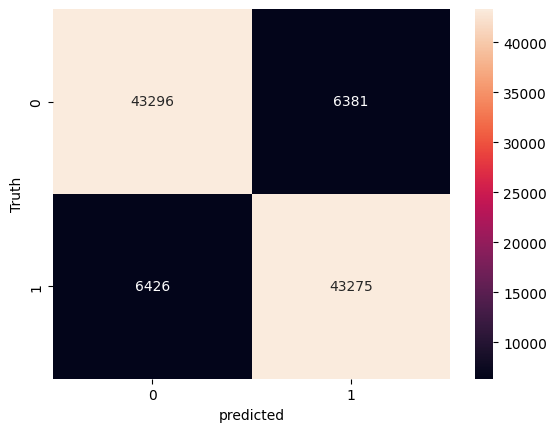

In [82]:
import matplotlib.pyplot  as plt 
import seaborn as sns 

sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('predicted')
plt.ylabel('Truth')

In [46]:
def sentiment_predict(new_sentence):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [67]:
sentiment_predict('전국 체감 33도 이상 찜통 …천둥·번개 동반 소나기(종합)[오늘날씨]')

1/1 [==============================] - 0s 49ms/step
98.39% 확률로 긍정 리뷰입니다.


In [56]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import os
import os
import openai
def get_news_summary(key_word):

    url = f'https://search.naver.com/search.naver?where=news&sm=tab_jum&query={key_word}'



    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36"}
    res = requests.get(url, headers= headers)
    soup = bs(res.text, 'html.parser')
    news_list = soup.find_all('div', attrs={'class':'info_group'})


    news_url_list = [] # 네이버 뉴스 url 리스트
    new_article_list= [] # 네이버 뉴스 기사 통합 리스트
    new_article_head_list =[] 
    for i in range(9): # 최대 5개 정도만 추출
        news_article = news_list[i].find_all("a", attrs={"class":"info"})
        print(i,' 번쨰')
        if len(news_article) > 1:
            news_nm_url = news_article[1].get('href')
            news_url_list.append(news_nm_url)
            res = requests.get(news_nm_url, headers=headers)
            soup = bs(res.text, 'lxml')
            try:
                news_article_nm = soup.find_all('div', attrs = {'class': 'newsct_article _article_body'})
                news_article_head = soup.find( attrs = {'id': 'title_area'})
                news_article_text = news_article_nm[0].get_text()
                news_article_head_text = news_article_head.get_text()
                new_article_list.append(news_article_text)
                new_article_head_list.append(news_article_head_text)
            except:
                pass
    return (new_article_list, new_article_head_list)
        


In [57]:
news_list = get_news_summary('')

0  번쨰
1  번쨰
2  번쨰
3  번쨰
4  번쨰
5  번쨰
6  번쨰
7  번쨰
8  번쨰


In [64]:
for i in range(9):
    print(news_list[1][i])
    print(sentiment_predict(news_list[1][i]))


경찰 '신림동 칼부림' 30대 얼굴·이름 공개 오늘 결론
1/1 [==============================] - 0s 41ms/step
66.22% 확률로 부정 리뷰입니다.
None
칼부림 전날 PC 부수고 폰 초기화...신림 살해범 “범행 계획했다”
1/1 [==============================] - 0s 41ms/step
67.50% 확률로 긍정 리뷰입니다.
None
10분전 흉기 훔쳐 신림동 도착 직후 칼부림(종합2보)
1/1 [==============================] - 0s 53ms/step
94.21% 확률로 부정 리뷰입니다.
None
10분 전 흉기 훔쳐 신림동 도착 직후 칼부림
1/1 [==============================] - 0s 42ms/step
83.37% 확률로 부정 리뷰입니다.
None
칼부림 피의자, 신림동 난동 이번 처음 아니야
1/1 [==============================] - 0s 54ms/step
73.23% 확률로 부정 리뷰입니다.
None
'묻지마' 흉기난동범 10분전 흉기 훔쳐 신림동 도착 직후 칼부림
1/1 [==============================] - 0s 46ms/step
95.31% 확률로 부정 리뷰입니다.
None
'묻지마 칼부림' 트라우마 겪는 신림동 골목 상인들
1/1 [==============================] - 0s 42ms/step
70.90% 확률로 긍정 리뷰입니다.
None
2040 쇼핑 검색 1위가 ‘호신용품’, 신림동 칼부림 후 남성도 찾는다
1/1 [==============================] - 0s 43ms/step
61.94% 확률로 긍정 리뷰입니다.
None
신림동 칼부림 6일 전…제기동서도 39cm 흉기난동 있었다
1/1 [==============================] - 0s 50ms/step
78.58% 확률로 부정 리뷰입니다.
None


In [63]:
len(news_list[1])

9

In [26]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import os
import os
import openai
def get_news_summary(key_word):

    url = f'https://search.naver.com/search.naver?where=news&sm=tab_jum&query={key_word}'



    headers = {"User-Agent": "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36"}
    res = requests.get(url, headers= headers)
    soup = bs(res.text, 'html.parser')
    news_list = soup.find_all('div', attrs={'class':'info_group'})


    news_url_list = [] # 네이버 뉴스 url 리스트
    new_article_list= [] # 네이버 뉴스 기사 통합 리스트
    new_article_head_list =[] 
    sec_article_list = []
    for i in range(9): # 최대 5개 정도만 추출
        news_article = news_list[i].find_all("a", attrs={"class":"info"})
        print(i)
        if len(news_article) > 1:
            news_nm_url = news_article[1].get('href')
            print(news_nm_url)
            news_url_list.append(news_nm_url)
            res = requests.get(news_nm_url, headers=headers)
            soup = bs(res.text, 'lxml')
            try:
                news_article_nm = soup.find_all('div', attrs = {'class': 'newsct_article _article_body'})
                aritle = soup.find(attrs={'class' : 'go_trans _article_content'}).text
                print(i, '번쨰껄 가지고 옵니다. ')
                sec_article_list.append(aritle)
                news_article_head = soup.find( attrs = {'id': 'title_area'})
                news_article_text = news_article_nm[0].get_text()
                news_article_head_text = news_article_head.get_text()
                new_article_list.append(news_article_text)
                new_article_head_list.append(news_article_head_text)
            except:
                pass
    return (new_article_list, new_article_head_list ,sec_article_list )
        


In [68]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd
import os
import os
import openai
keyword= '스즈메의 문단속 평점'
url = f'https://search.naver.com/search.naver?where=nexearch&sm=tab_etc&mra=bkEw&pkid=68&os=26045925&qvt=0&query={keyword}'



headers = {"User-Agent": "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36"}
res = requests.get(url, headers= headers)
soup = bs(res.text, 'html.parser')

soup
# news_list = soup.find_all('div', attrs={'class':'info_group'})


# news_url_list = [] # 네이버 뉴스 url 리스트
# new_article_list= [] # 네이버 뉴스 기사 통합 리스트
# new_article_head_list =[] 
# sec_article_list = []
# for i in range(9): # 최대 5개 정도만 추출
#     news_article = news_list[i].find_all("a", attrs={"class":"info"})
#     print(i)
#     if len(news_article) > 1:
#         news_nm_url = news_article[1].get('href')
#         print(news_nm_url)
#         news_url_list.append(news_nm_url)
#         res = requests.get(news_nm_url, headers=headers)
#         soup = bs(res.text, 'lxml')
#         try:
#             news_article_nm = soup.find_all('div', attrs = {'class': 'newsct_article _article_body'})
#             aritle = soup.find(attrs={'class' : 'go_trans _article_content'}).text
#             print(i, '번쨰껄 가지고 옵니다. ')
#             sec_article_list.append(aritle)
#             news_article_head = soup.find( attrs = {'id': 'title_area'})
#             news_article_text = news_article_nm[0].get_text()
#             news_article_head_text = news_article_head.get_text()
#             new_article_list.append(news_article_text)
#                 new_article_head_list.append(news_article_head_text)

        


<!DOCTYPE html>
 <html lang="ko"><head> <meta charset="utf-8"/> <meta content="always" name="referrer"/> <meta content="telephone=no,address=no,email=no" name="format-detection"/> <meta content="width=device-width,initial-scale=1.0,maximum-scale=2.0" name="viewport"/> <meta content="스즈메의 문단속 평점 : 네이버 통합검색" property="og:title"> <meta content="https://ssl.pstatic.net/sstatic/search/common/og_v3.png" property="og:image"/> <meta content="'스즈메의 문단속 평점'의 네이버 통합검색 결과입니다." property="og:description"/> <meta content="'스즈메의 문단속 평점'의 네이버 통합검색 결과입니다." lang="ko" name="description"/> <title>스즈메의 문단속 평점 : 네이버 통합검색</title> <link href="https://ssl.pstatic.net/sstatic/search/favicon/favicon_191118_pc.ico" rel="shortcut icon"/> <link href="https://ssl.pstatic.net/sstatic/search/opensearch-description.https.xml" rel="search" title="Naver" type="application/opensearchdescription+xml"><script> if (top.frames.length!=0 || window!=top) window.open(location, "_top"); </script><link href="https://ssl.pstatic.net

In [25]:
from selenium import  webdriver 
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
# from webdriver_manager.chrome import ChromeDriverManager 
import time 

def find_movie_reviews(search,  n: int )  ->  list:
    options = Options()

    options.add_experimental_option('detach', True) 

    # service = Service(ChromeDriverManager().install())
    options.add_argument('--start-maximized')
    driver = webdriver.Chrome(options=options)
    url =f'https://search.naver.com/search.naver?where=nexearch&sm=top_sug.pat&fbm=0&acr=1&acq=%EC%8A%A4%EC%A6%88%EB%A9%94%EC%9D%98+%EB%AC%B8%EB%8B%A8%EC%86%8D+%ED%8F%89%EC%A0%90&qdt=0&ie=utf8&query={search}'

    driver.get(url)

    driver.implicitly_wait(time_to_wait=10)
    area_card_outer = driver.find_element(By.CSS_SELECTOR, '.area_card_outer._item_wrapper')
    area_card_items = area_card_outer.find_elements(By.CSS_SELECTOR  , '.area_card._item')
    reviews= []
    for area_card_item in area_card_items:

        review  =  area_card_item.find_element(By.CSS_SELECTOR  ,'.desc._text').text
        reviews.append(review)
        n -=1
        if n==0:
            break
    return reviews
reviews = find_movie_reviews('범죄도시+평점', 10)


0
https://n.news.naver.com/mnews/article/082/0001223540?sid=101
0 번쨰껄 가지고 옵니다. 
1
https://n.news.naver.com/mnews/article/003/0011991112?sid=101
1 번쨰껄 가지고 옵니다. 
2
https://n.news.naver.com/mnews/article/018/0005535759?sid=101
2 번쨰껄 가지고 옵니다. 
3
https://n.news.naver.com/mnews/article/366/0000918823?sid=105
3 번쨰껄 가지고 옵니다. 
4
5
https://n.news.naver.com/mnews/article/003/0011991309?sid=101
5 번쨰껄 가지고 옵니다. 
6
https://n.news.naver.com/mnews/article/009/0005162587?sid=101
6 번쨰껄 가지고 옵니다. 
7
https://n.news.naver.com/mnews/article/001/0014084082?sid=101
7 번쨰껄 가지고 옵니다. 
8


In [23]:
article_list

['\n\n\n\n\nLG전자 퓨리케어 오브제컬렉션 정수기 유튜브 광고 영상 이미지.LG전자 제공LG전자는 퓨리케어 오브제컬렉션 정수기의 편리한 음성인식 기능을 소개한 광고영상이 공개 약 1개월 만에 누적 조회수 1000만 뷰를 돌파했다고 24일 밝혔다.LG전자는 지난 달 ‘어떤 물의 레시피 앞에서도 손 하나 까딱하지 않으리’라는 카피를 주제로 비건 편과 홈 애프터눈티 편, 발레리나 편, 종합편 등 총 4편으로 된 유튜브 광고영상 ‘물을 다루는 완벽한 능력’을 선보였다. LG 퓨리케어 오브제컬렉션 정수기만의 음성인식 기능으로 다양한 고객의 물 사용 능력을 업그레이드 시켜준다는 메시지를 강조했다.‘비건 편’에서는 채식을 즐기는 커플이 채소를 사용한 그린커리의 레시피대로 “하이 엘지, 물 930밀리 줘”라고 하면 LG 퓨리케어 정수기가 알아서 원하는 용량의 물을 딱 맞게 따라준다. ‘홈 애프터눈티 편’에서도 음성인식만으로 애플라임티에 알맞게 물 용량을 210mL로 조절하는 모습을 보여준다.영상을 본 고객들은 “말 한마디면 다 된다”, “요리할 때 손이 모자라는데 말로 하면 너무 좋다”, “정수기 광고가 힙하다”는 등 댓글을 통해 긍정적인 반응을 보였다.LG전자는 지난해 8월 국내 최초로 음성인식과 맞춤 출수 기능을 적용한 정수기 신제품을 선보였다. 이 제품은 음성만으로 출수량을 10mL 단위로 정밀하게 설정하고 물을 받을 수 있다. 예를 들어 고객이 “하이 엘지!”라고 부른 후 “냉수 550mL 줘”라고 말하면 버튼을 조작하지 않고 물 용량을 원하는대로 조절할 수 있다.차별화된 음성인식의 편리함이 고객들로부터 인정받으면서 LG전자의 올 상반기 정수기 판매량은 전년 동기 대비 20% 이상 늘었다.LG전자는 출수량과 물 온도를 조절하기 위해 여러 번 버튼을 누르거나 손에 음식물이 묻어 버튼을 누르기 어려운 경우 등 기존 정수기 사용 고객의 페인포인트(고객이 불편함을 느끼는 지점)를 ‘음성인식 기능’으로 해결한 것이다.음성인식 기능은 어린 아이나 장애인 등 정수기 상단

In [ ]:


def sentiment_predict(new_sentence , max_len= 80):
  new_sentence = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_sentence)
  new_sentence = mecab.morphs(new_sentence)
  new_sentence = [word for word in new_sentence if not word in stopwords]
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen = max_len)

  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [ ]:
from selenium import  webdriver 
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
# from webdriver_manager.chrome import ChromeDriverManager 
import time 

def find_movie_reviews(search,  n: int )  ->  list:
    options = Options()

    options.add_experimental_option('detach', True) 

    # service = Service(ChromeDriverManager().install())
    options.add_argument('--start-maximized')
    driver = webdriver.Chrome(options=options)
    url =f'https://search.naver.com/search.naver?where=nexearch&sm=top_sug.pat&fbm=0&acr=1&acq=%EC%8A%A4%EC%A6%88%EB%A9%94%EC%9D%98+%EB%AC%B8%EB%8B%A8%EC%86%8D+%ED%8F%89%EC%A0%90&qdt=0&ie=utf8&query={search}'

    driver.get(url)

    driver.implicitly_wait(time_to_wait=10)
    area_card_outer = driver.find_element(By.CSS_SELECTOR, '.area_card_outer._item_wrapper')
    area_card_items = area_card_outer.find_elements(By.CSS_SELECTOR  , '.area_card._item')
    reviews= []
    for area_card_item in area_card_items:

        review  =  area_card_item.find_element(By.CSS_SELECTOR  ,'.desc._text').text
        reviews.append(review)
        n -=1
        if n==0:
            break
    driver.close()
    return reviews

input_from_client = input()
reviews = find_movie_reviews(input_from_client, 10)

for review in reviews:
    print(review)
    print(sentiment_predict(review))

너무 고심없이 전작에 기대 후루룩 찍은 느낌
1/1 [==============================] - 4s 4s/step
62.01% 확률로 부정 리뷰입니다.
None
악역이 아무래도 전편보다는 덜 매력적
1/1 [==============================] - 0s 40ms/step
62.01% 확률로 부정 리뷰입니다.
None
이런 허술한 스토리로 천만 가는 거 보면 영화 흥행도 이미지 메이킹이 얼마나 중요한지 알게 된다
1/1 [==============================] - 0s 38ms/step
62.01% 확률로 부정 리뷰입니다.
None
1부터 2까지 다 재밌다고 하고 흥행도 됐길래 3은 봐야겠다 싶어서 개봉하자마자 문화의 날 봤는데 재밌긴 한데 내 스타일이 아님. 내용이 너무 없어. 마동석이 범인 패는 장면밖에 없음. 손익 분기점이 150만 이라던데 왜 그런지 알 것 같음. 진짜 뭔 연출, 영화 미술이랄 게 없음. 마동석...
1/1 [==============================] - 0s 39ms/step
62.01% 확률로 부정 리뷰입니다.
None
마동석 원툴영화이긴하지만 다음작품은 좀변화가 필요할거같음
1/1 [==============================] - 0s 36ms/step
62.01% 확률로 부정 리뷰입니다.
None
이제 슬슬 뇌절같다 ...ㅋㅋ
1/1 [==============================] - 0s 45ms/step
62.01% 확률로 부정 리뷰입니다.
None
나름 볼만은 합니다~ㅋㅋ
1/1 [==============================] - 0s 36ms/step
62.01% 확률로 부정 리뷰입니다.
None
19세 예고편 보고 기대한 것보다 15세라 덜 자극적이고 악역배우들이 생각보다 순하게 나왔음.1편부터 꾸준히 보고 있는데, 갈수록 자극적인 주제로 갈수록 덜 자극적이고, 완성도도 덜 한 느낌.파급력이 커지는 만큼 완성도도 올라갔

In [20]:
sentiment_predict('사랑해요')

1/1 [==============================] - 0s 47ms/step
62.01% 확률로 부정 리뷰입니다.


In [2]:
key_word= 'LG 전자'
url = f'https://search.naver.com/search.naver?where=news&sm=tab_jum&query={key_word}'



headers = {"User-Agent": "Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/44.0.2403.157 Safari/537.36"}
res = requests.get(url, headers= headers)
soup = bs(res.text, 'html.parser')
news_list = soup.find_all('div', attrs={'class':'info_group'})


news_url_list = [] # 네이버 뉴스 url 리스트
new_article_list= [] # 네이버 뉴스 기사 통합 리스트
new_article_head_list =[] 
for i in range(30):
    print(i,'번쨰')
    news_article = news_list.find_all("a", attrs={"class":"info"})

    news_nm_url = news_article[1].get('href')
    news_url_list.append(news_nm_url)
    res = requests.get(news_nm_url, headers=headers)
    soup = bs(res.text, 'lxml')

    news_article_nm = soup.find_all('div', attrs = {'class': 'newsct_article _article_body'})
    news_article_head = soup.find( attrs = {'id': 'title_area'})
    news_article_text = news_article_nm[0].get_text()
    news_article_head_text = news_article_head.get_text()
    print(news_nm_url)
    print(news_article_head_text)
    print(news_article_text)

NameError: name 'requests' is not defined

In [54]:
if len(news_article) > 1 :
    print('ha')